In [1]:
%matplotlib inline
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac, unweighted_unifrac_fast, weighted_unifrac_fast
import pandas as pd
from qiime_default_reference import get_reference_tree
from skbio import TreeNode
from skbio.diversity._fast_base import index_tree
from biom import load_table
from skbio.diversity.beta._fast_unifrac import make_pdist, unifrac, w_unifrac
from skbio.diversity.beta import pw_distances
import numpy as np

np.random.seed(1234)

bench_data = load_table('data/AG_even10k.biom')
tree = TreeNode.read(get_reference_tree())

# correct a missing branchlength in the reference tree
for n in tree.traverse(include_self=False):
    if n.length is None:
        n.length = 0.0
        
def make_and_run_pw_distances(method, counts, otu_ids, tree, normalized=False, ids=None):
    metric, counts_array, length = make_pdist(counts, otu_ids, tree, normalized=normalized, metric=method)
    return pw_distances(metric, counts_array, ids=ids)

def get_random_samples(n, tree, shear):
    samples = bench_data.subsample(n, by_id=True)
    samples.filter(lambda v, i, md: v.sum() > 0, axis='observation')  # remove zero'd observations in place
    ids = samples.ids().copy()
    otu_ids = samples.ids(axis='observation').copy()
    otu_data = samples.matrix_data.toarray().T
    if shear:
        t = tree.shear(otu_ids)
    else:
        t = tree.copy()
        
    return ids, otu_ids, otu_data, t

Verify producing the sames results.

In [2]:
import numpy.testing as npt

ids, otu_ids, otu_data, t = get_random_samples(10, tree, True)

fu_mat = make_and_run_pw_distances(unifrac, otu_data, otu_ids=otu_ids, tree=t)
u_mat = pw_distances(unweighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
fwu_mat = make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t)
wu_mat = pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
fwun_mat = make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
wun_mat = pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)

npt.assert_almost_equal(fu_mat.data, u_mat.data)
npt.assert_almost_equal(fwu_mat.data, wu_mat.data)
npt.assert_almost_equal(fwun_mat.data, wun_mat.data)

General timing

In [3]:
%timeit make_and_run_pw_distances(unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit pw_distances(unweighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
%timeit pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)

10 loops, best of 3: 35.6 ms per loop
1 loops, best of 3: 1.28 s per loop
10 loops, best of 3: 31.9 ms per loop
1 loops, best of 3: 1.43 s per loop
10 loops, best of 3: 33.7 ms per loop
1 loops, best of 3: 1.88 s per loop


API testing, making the same method calls and verifying results. Intentionally doing the full matrix in the (very unexpected event) that d(u, v) != d(v, u)

In [4]:
method_sets = [[unweighted_unifrac, unweighted_unifrac_fast], 
               [weighted_unifrac, weighted_unifrac_fast]]

ids, otu_ids, otu_data, t = get_random_samples(5, tree, True)

for i in range(len(otu_data)):
    for j in range(len(otu_data)):
        for method_set in method_sets:
            method_results = []
            for method in method_set:
                method_results.append(method(otu_data[i], otu_data[j], otu_ids, t))
            npt.assert_almost_equal(*method_results)

`pw_distances` scaling tests.

In [5]:
sample_counts = [2, 4, 8, 16, 32]

uw_times = []
uwf_times = []
w_times = []
wn_times = []
wf_times = []
wnf_times = []
uw_times_p = []
uwf_times_p = []
w_times_p = []
wn_times_p = []
wf_times_p = []
wnf_times_p = []

for n_samples in sample_counts:
    ids, otu_ids, otu_data, t = get_random_samples(n_samples, tree, True)

    # sheared trees
    for times, method in [[uw_times_p, unweighted_unifrac], [w_times_p, weighted_unifrac]]:
        result = %timeit -o pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)

    result = %timeit -o pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
    wn_times_p.append(result.best)
    
    for times, method in [[uwf_times_p, unifrac], [wf_times_p, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
    wnf_times_p.append(result.best)     
    
    # full trees
    for times, method in [[uw_times, unweighted_unifrac], [w_times, weighted_unifrac]]:
        result = %timeit -o pw_distances(method, otu_data, otu_ids=otu_ids, tree=tree)
        times.append(result.best)

    result = %timeit -o pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=tree, normalized=True)
    wn_times.append(result.best)    
        
    for times, method in [[uwf_times, unifrac], [wf_times, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=tree)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=tree, normalized=True)
    wnf_times.append(result.best)     

10 loops, best of 3: 35.6 ms per loop
10 loops, best of 3: 23.7 ms per loop
10 loops, best of 3: 30.5 ms per loop
100 loops, best of 3: 9.84 ms per loop
100 loops, best of 3: 12 ms per loop
100 loops, best of 3: 12.4 ms per loop
1 loops, best of 3: 385 ms per loop
1 loops, best of 3: 384 ms per loop
1 loops, best of 3: 427 ms per loop
1 loops, best of 3: 1.76 s per loop
1 loops, best of 3: 1.67 s per loop
1 loops, best of 3: 2.08 s per loop
10 loops, best of 3: 166 ms per loop
1 loops, best of 3: 235 ms per loop
1 loops, best of 3: 210 ms per loop
100 loops, best of 3: 16.7 ms per loop
100 loops, best of 3: 16.9 ms per loop
10 loops, best of 3: 25.2 ms per loop
1 loops, best of 3: 2.42 s per loop
1 loops, best of 3: 2.68 s per loop
1 loops, best of 3: 2.46 s per loop
1 loops, best of 3: 1.63 s per loop
1 loops, best of 3: 1.81 s per loop
1 loops, best of 3: 1.87 s per loop
1 loops, best of 3: 641 ms per loop
1 loops, best of 3: 814 ms per loop
1 loops, best of 3: 1.06 s per loop
10 loo

u	: unweighted unifrac
w	: weighted unifrac
fu	: unweighted fast unifrac
fw	: weighted fast unifrac
wn	: weighted normalized unifrac
fwn	: weighted normalized fast unifrac
u-p	: unweighted unifrac pruned tree
w-p	: weighted unifrac pruned tree
fu-p	: unweighted fast unifrac pruned tree
fw-p	: weighted fast unifrac pruned tree
wn-p	: weighted normalized unifrac pruned tree
fwn-p	: weighted normalized fast unifrac pruned tree


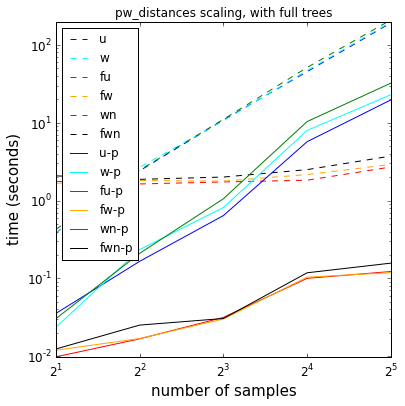

In [8]:
fig = figure(figsize=(6,6))
plot(sample_counts, uw_times, '--', color='blue')
plot(sample_counts, w_times, '--', color='cyan')
plot(sample_counts, uwf_times, '--', color='red')
plot(sample_counts, wf_times, '--', color='orange')
plot(sample_counts, wn_times, '--', color='green')
plot(sample_counts, wnf_times, '--', color='black')

plot(sample_counts, uw_times_p, color='blue')
plot(sample_counts, w_times_p, color='cyan')
plot(sample_counts, uwf_times_p, color='red')
plot(sample_counts, wf_times_p, color='orange')
plot(sample_counts, wn_times_p, color='green')
plot(sample_counts, wnf_times_p, color='black')

legend_acronyms = [
    ('u', 'unweighted unifrac'), 
    ('w', 'weighted unifrac'), 
    ('fu', 'unweighted fast unifrac'), 
    ('fw', 'weighted fast unifrac'), 
    ('wn', 'weighted normalized unifrac'), 
    ('fwn', 'weighted normalized fast unifrac'), 
    ('u-p', 'unweighted unifrac pruned tree'), 
    ('w-p', 'weighted unifrac pruned tree'), 
    ('fu-p', 'unweighted fast unifrac pruned tree'), 
    ('fw-p', 'weighted fast unifrac pruned tree'), 
    ('wn-p', 'weighted normalized unifrac pruned tree'), 
    ('fwn-p', 'weighted normalized fast unifrac pruned tree')
]

legend([i[0] for i in legend_acronyms], loc=2)
title("pw_distances scaling, with full trees")
xlabel('number of samples', fontsize=15)
ylabel('time (seconds)', fontsize=15)
xscale('log', basex=2)
yscale('log')
xlim(min(sample_counts), max(sample_counts))
ylim(min(uwf_times_p), max(w_times))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
savefig('edu vs fast.png')

for ac, name in legend_acronyms:
    print("%s\t: %s" % (ac, name))

Extend to larger sample counts for fast unifrac

In [11]:
sample_counts_ext = [64, 128, 256, 512, 1024]
for n_samples in sample_counts_ext:
    print("sample count: %d" % n_samples)
    ids, otu_ids, otu_data, t = get_random_samples(n_samples, tree, True)

    for times, method in [[uwf_times_p, unifrac], [wf_times_p, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
    wnf_times_p.append(result.best)     
    
    for times, method in [[uwf_times, unifrac], [wf_times, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=tree)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=tree, normalized=True)
    wnf_times.append(result.best) 

sample count: 128
1 loops, best of 3: 1.52 s per loop
1 loops, best of 3: 1.24 s per loop
1 loops, best of 3: 1.83 s per loop
1 loops, best of 3: 19.1 s per loop
1 loops, best of 3: 20.9 s per loop
1 loops, best of 3: 29.7 s per loop
sample count: 256
1 loops, best of 3: 6.87 s per loop
1 loops, best of 3: 5.61 s per loop
1 loops, best of 3: 8.61 s per loop
1 loops, best of 3: 1min 8s per loop
1 loops, best of 3: 1min 36s per loop
1 loops, best of 3: 2min 38s per loop
sample count: 512
1 loops, best of 3: 30.7 s per loop
1 loops, best of 3: 24.7 s per loop
1 loops, best of 3: 40.3 s per loop
1 loops, best of 3: 3min 59s per loop
1 loops, best of 3: 4min 19s per loop
1 loops, best of 3: 6min 53s per loop
sample count: 1024
1 loops, best of 3: 2min 17s per loop
1 loops, best of 3: 1min 53s per loop
1 loops, best of 3: 3min 2s per loop
1 loops, best of 3: 16min 24s per loop
1 loops, best of 3: 17min 51s per loop
The slowest run took 18.87 times longer than the fastest. This could mean tha

fu	: unweighted fast unifrac
fw	: weighted fast unifrac
fwn	: weighted normalized fast unifrac
fu-p	: unweighted fast unifrac pruned tree
fw-p	: weighted fast unifrac pruned tree
fwn-p	: weighted normalized fast unifrac pruned tree


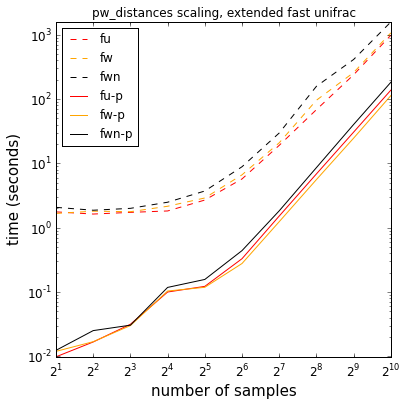

In [12]:
# at 4GB mem for 1024 set, counts array in this case is ~(1024 x 180000) or approx 1.4GB
# so not _that_ bad given the other resident data structures and notebook state.

sample_counts_ext = [64, 128, 256, 512, 1024]

sample_counts_full = sample_counts[:]
sample_counts_full.extend(sample_counts_ext)
                                  
fig = figure(figsize=(6,6))
plot(sample_counts_full, uwf_times, '--', color='red')
plot(sample_counts_full, wf_times, '--', color='orange')
plot(sample_counts_full, wnf_times, '--', color='black')
plot(sample_counts_full, uwf_times_p, color='red')
plot(sample_counts_full, wf_times_p, color='orange')
plot(sample_counts_full, wnf_times_p, color='black')

legend_acronyms = [
    ('fu', 'unweighted fast unifrac'), 
    ('fw', 'weighted fast unifrac'), 
    ('fwn', 'weighted normalized fast unifrac'), 
    ('fu-p', 'unweighted fast unifrac pruned tree'), 
    ('fw-p', 'weighted fast unifrac pruned tree'), 
    ('fwn-p', 'weighted normalized fast unifrac pruned tree')
]

legend([i[0] for i in legend_acronyms], loc=2)
title("pw_distances scaling, extended fast unifrac")
xlabel('number of samples', fontsize=15)
ylabel('time (seconds)', fontsize=15)
xscale('log', basex=2)
yscale('log')
xlim(min(sample_counts_full), max(sample_counts_full))
ylim(min(uwf_times_p), max([uwf_times[-1], wf_times[-1], wnf_times[-1]]))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
savefig('fast extended.png')

for ac, name in legend_acronyms:
    print("%s\t: %s" % (ac, name))

fu	: unweighted fast unifrac
fw	: weighted fast unifrac
fwn	: weighted normalized fast unifrac
fu-p	: unweighted fast unifrac pruned tree
fw-p	: weighted fast unifrac pruned tree
fwn-p	: weighted normalized fast unifrac pruned tree


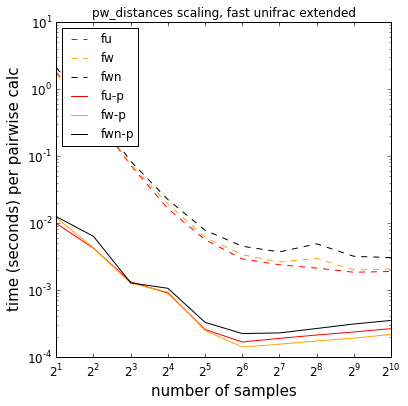

In [20]:
n_upper_tri = lambda n: max((n**2 / 2.0) - n, 1)
time_per_calc = lambda times, counts: [(t / n_upper_tri(c)) for t, c in zip(times, counts)]

fig = figure(figsize=(6,6))
plot(sample_counts_full, time_per_calc(uwf_times, sample_counts_full), '--', color='red')
plot(sample_counts_full, time_per_calc(wf_times, sample_counts_full), '--', color='orange')
plot(sample_counts_full, time_per_calc(wnf_times, sample_counts_full), '--', color='black')
plot(sample_counts_full, time_per_calc(uwf_times_p, sample_counts_full), color='red')
plot(sample_counts_full, time_per_calc(wf_times_p, sample_counts_full), color='orange')
plot(sample_counts_full, time_per_calc(wnf_times_p, sample_counts_full), color='black')

legend_acronyms = [
    ('fu', 'unweighted fast unifrac'), 
    ('fw', 'weighted fast unifrac'), 
    ('fwn', 'weighted normalized fast unifrac'), 
    ('fu-p', 'unweighted fast unifrac pruned tree'), 
    ('fw-p', 'weighted fast unifrac pruned tree'), 
    ('fwn-p', 'weighted normalized fast unifrac pruned tree')
]

legend([i[0] for i in legend_acronyms], loc=2)
title("pw_distances scaling, fast unifrac extended")
xlabel('number of samples', fontsize=15)
ylabel('time (seconds) per pairwise calc', fontsize=15)
xscale('log', basex=2)
yscale('log')
xlim(min(sample_counts_full), max(sample_counts_full))
#ylim(min(uwf_times_p), max([uwf_times[-1], wf_times[-1], wnf_times[-1]]))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
savefig('fast extended per calc.png')

for ac, name in legend_acronyms:
    print("%s\t: %s" % (ac, name))